## Week 4: More data viz + APIs

Feb 13, 2019

## Today's Agenda

- recap of last week's exercise
- more interactive data visualization: the pyViz ecosystem
- getting started with APIs

## Recap: last week's exercise

## Step 1: Load the assessment data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs

In [2]:
url = "https://raw.githubusercontent.com/MUSA-620-Spring-2019/week-3/master/data/opa_residential.csv"
data = pd.read_csv(url)
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

## Step 2: convert to a GeoDataFrame

Add `Coordinates` column holding `Point()` objects

In [3]:
from shapely.geometry import Point

In [4]:
data['Coordinates'] = list(zip(data['lng'], data['lat']))
data['Coordinates'] = data['Coordinates'].apply(Point)

Create the `GeoDataFrame` object, specifying the input CRS of the data frame coordinates.

<div class="alert alert-info" style="font-size:100%">
<b>REMEMBER</b>: <br>

<ul>
    <li>The "crs" used here should be the CRS of the <b>input geometry</b> </li>
    <li>In our case, the input latitude/longitudes are EPSG code 4326</li>
    <li>It should specified as a dictionary: <code>{'init': 'epsg:4326'}</code></li>
</ul>
</div>

In [5]:
input_crs = {'init': 'epsg:4326'}
data = gpd.GeoDataFrame(data, geometry='Coordinates', crs=input_crs)

Finally, we can convert our input data (in EPSG 4326) to Web Mercator (EPSG 3857)

In [6]:
data = data.to_crs(epsg=3857)

## Step 3: do a spatial join with Zillow neighbohoods

<div class="alert alert-info" style="font-size:100%">
<b>REMEMBER</b>: <br>
    The <code>sjoin()</code> function will merge two GeoDataFrames together, based on the spatial relationships of the two geometries.
</div>

In [7]:
# load the Zillow data from GitHub
url = "https://raw.githubusercontent.com/MUSA-620-Spring-2019/week-3/master/data/zillow_neighborhoods.geojson"
zillow = gpd.read_file(url)

# convert the CRS to Web Mercator
zillow = zillow.to_crs(epsg=3857)

In [8]:
# perform the spatial join
gdata = gpd.sjoin(data, zillow, op='within', how='left')

/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


## Step 4: make a choropleth of the median market value by neighborhood

Hints: 
- you will need to group by Zillow neighborhood
- calculate the median market value per neighborhood
- join with the Zillow neighborhood GeoDataFrame

Calculate the median market value for each Zillow neighborhood:

In [9]:
grouped = gdata.groupby('ZillowName')
median_values = grouped['market_value'].median().reset_index()

Merge your Zillow GeoDataFrame with the median market values. 


<div class="alert alert-info" style="font-size:100%">
<b>IMPORTANT</b>: <br>
  <ul>
      <li>The Zillow GeoDataFrame should be the first ("left") argument of the merge</li>
      <li>Be sure that the merged data frame is a GeoDataFrame, as opposed to just a DataFrame</li>
  </ul>
</div>

In [10]:
median_values = pd.merge(zillow, median_values, on='ZillowName')
print(type(median_values))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [11]:
median_values['market_value'] /= 1e3 # in thousands

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
# configure some default plotting parameters
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3

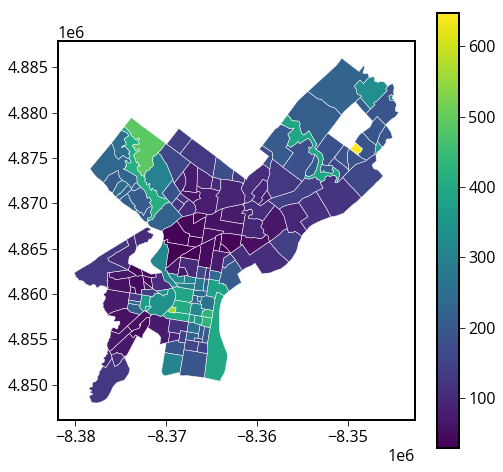

In [14]:
ax = median_values.plot(column='market_value', 
                   edgecolor='white',  linewidth=0.5, legend=True)
ax.figure.set_size_inches((8,8))

## Step 5: make a hex bin map of median assessments

Hints: 
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

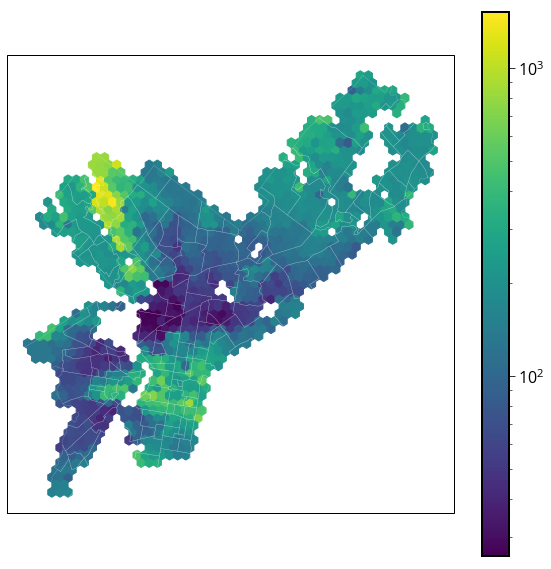

In [15]:
# create the axes
crs = ccrs.epsg('3857') # web mercator
ax = plt.axes(projection=crs)

# use the .x and .y attributes
vals = ax.hexbin(gdata.geometry.x, 
                 gdata.geometry.y, 
                 C=gdata.market_value/1e3, # market value in thousands
                 reduce_C_function=np.median, # calculate median for each bin
                 bins='log', # take the median of log(market value)
                 gridsize=50)

# add the zillow geometry boundaries
ax.add_geometries(zillow.geometry, crs=crs, facecolor='none', 
                  edgecolor='white', linewidth=0.25, alpha=0.5)

# adjust the figure size
ax.figure.set_size_inches((10,10))

# add a legend
cbar = plt.colorbar(vals)
cbar.ax.tick_params(labelsize=16) 

## Step 6: Use altair to make an interactive choropleth

In [16]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

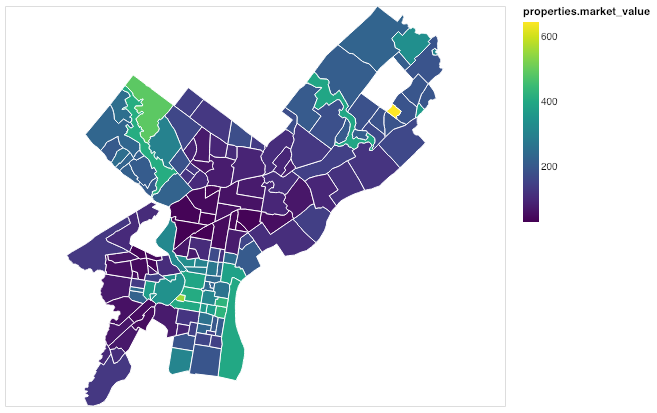

In [17]:
# create an altair data source from a GeoJSON representation
data  = alt.InlineData(values=median_values.to_crs(epsg=4326).to_json(),
                       format=alt.DataFormat(property='features',type='json'))

# plot map, where variables ares nested within `properties`, 
alt.Chart(data).mark_geoshape(
    stroke='white',
).properties(
    width=500,
    height=400,
    projection={"type":'mercator'},
).encode(
    tooltip=['properties.market_value:Q', 'properties.ZillowName:N'],
    color='properties.market_value:Q'
)

## Recap: Data viz in Python

<center>
    <img src=attachment:landscape_hv_nx.png width=700></img>
</center>
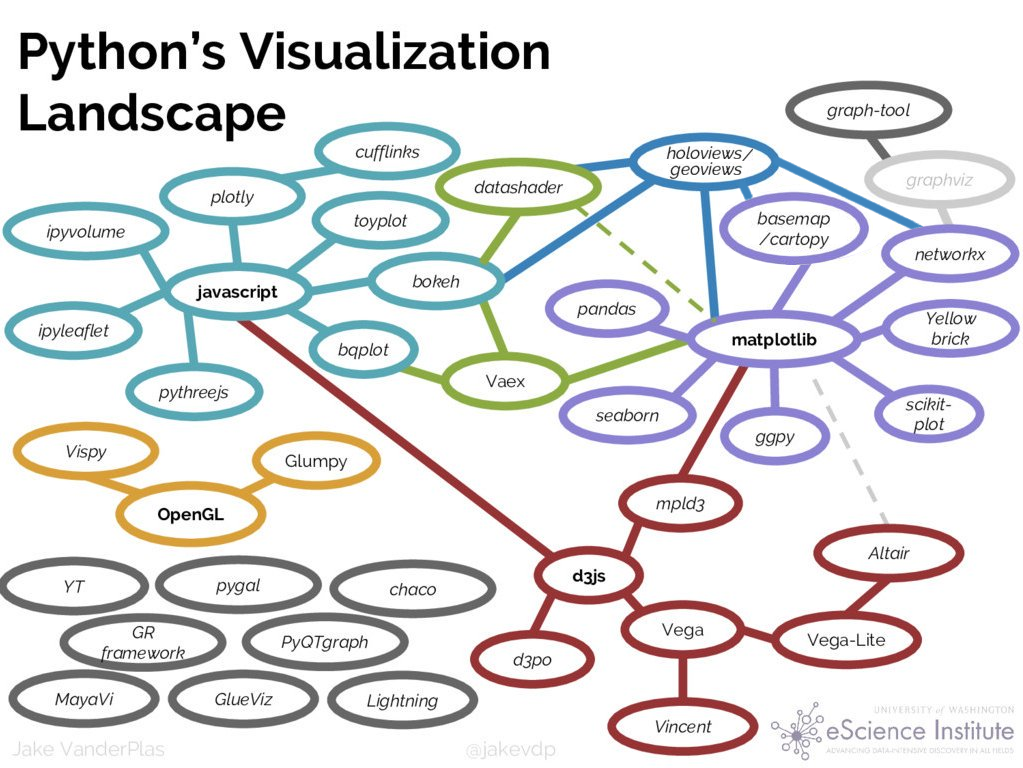

## What have we learned so far

### Matplotlib

- the classic, most flexible library
- can handle geographic data well
- overly verbose syntax, syntax is not declarative 

### Pandas

- quick, built-in interface
- not as many features as other libraries

### seaborn

- best for visualizing complex relationships between variables
- improves matplotlib's syntax: more declarative

### altair

- easy, declarative syntax
- lots of interactive features
- complex code with minimal amounts of code

## We'll learn one more today...

<center>
    <img src=attachment:landscape_hv_nx_pyviz.png width=600></img>
</center>
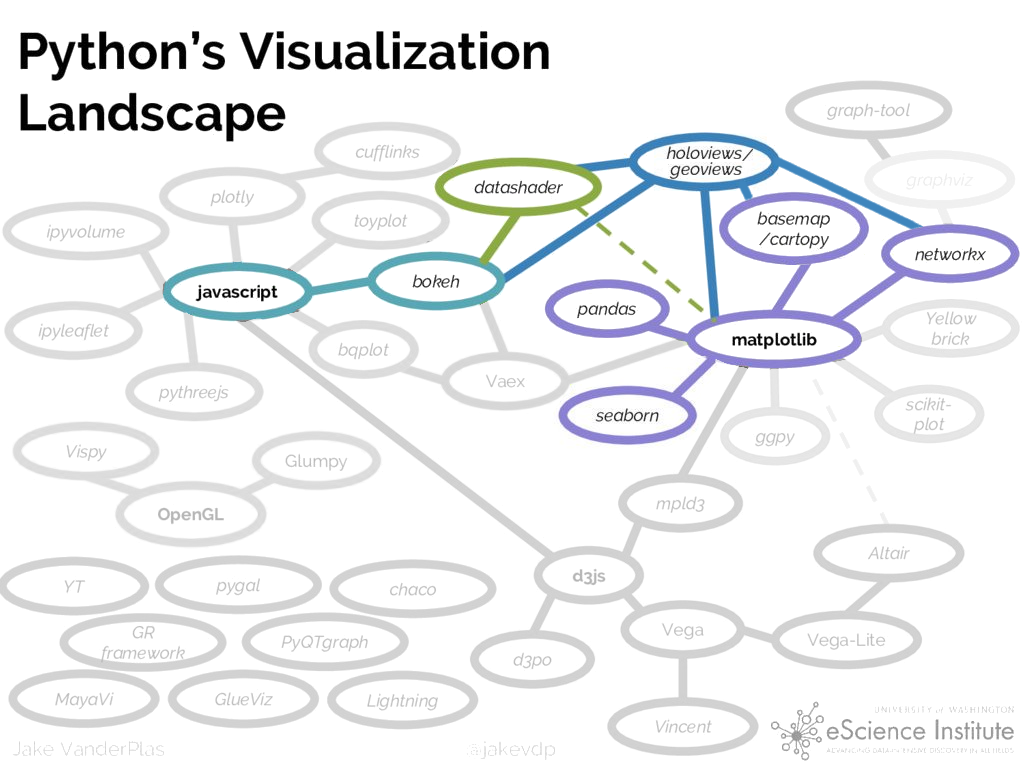

## A set of coordinated visualization libraries in Python

<center>
    <a href=http://pyviz.org/>
        <img src=attachment:PyViz_logo_wm.png width=200></img>
    </a>
</center>
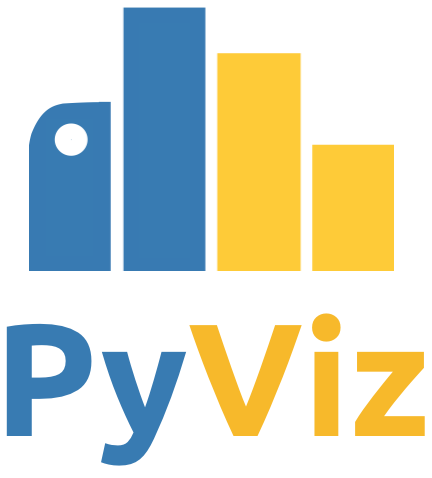

<center>
    <img src=attachment:Screen%20Shot%202019-02-11%20at%2010.41.54%20PM.png width=700></img>
</center>
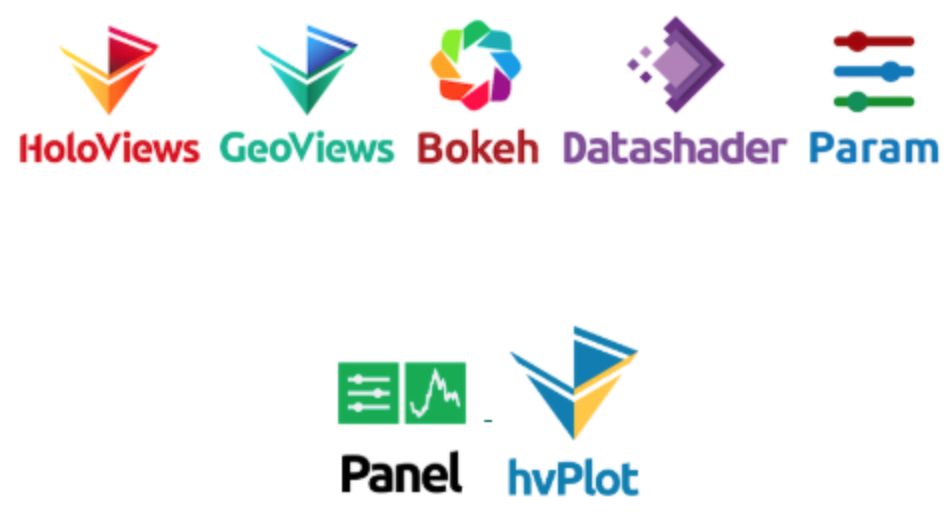

### Today: `hvPlot`

### Later in the course: `Datashader`, `Param`, `Panel`

## A quick overview

- **Bokeh**: creating interactive visualizations using Javascript using Python
- **HoloViews**: a declarative, high-level library for creating bokeh libraries

### $\rightarrow$ Similar to altair and Vega

## A significant pro: 

GeoViews builds on HoloViews to add support for geographic data

## The major con: 

- All are relatively new
- Bokeh is the most well-tested
- HoloViews, GeoViews, hvPlot are being actively developed but are very promising

## How does `hvPlot` fit in?

## The `hvPlot` package

It's **very new**: officially released 11 days ago

In [18]:
%%html 

<center>
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">We are very pleased officially announce the release of hvPlot! It provides a high-level plotting API for the PyData ecosystem including <a href="https://twitter.com/pandas_dev?ref_src=twsrc%5Etfw">@pandas_dev</a>, <a href="https://twitter.com/xarray_dev?ref_src=twsrc%5Etfw">@xarray_dev</a>, <a href="https://twitter.com/dask_dev?ref_src=twsrc%5Etfw">@dask_dev</a>, <a href="https://twitter.com/geopandas?ref_src=twsrc%5Etfw">@geopandas</a> and more, generating interactive <a href="https://twitter.com/datashader?ref_src=twsrc%5Etfw">@datashader</a> and <a href="https://twitter.com/BokehPlots?ref_src=twsrc%5Etfw">@BokehPlots</a>. <a href="https://t.co/Loc5XElJUL">https://t.co/Loc5XElJUL</a></p>&mdash; HoloViews (@HoloViews) <a href="https://twitter.com/HoloViews/status/1092409050283819010?ref_src=twsrc%5Etfw">February 4, 2019</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
</center>


## Main use

Quickly generate Holoviews/GeoViews interactive plots from your pandas/geopandas data

An interface just like the `pandas` plot() function, but **much** more useful.

## Let's load some data to try out

In [19]:
# let's load the measles data from week 2
url = "https://raw.githubusercontent.com/MUSA-620-Spring-2019/week-2/master/data/measles_incidence.csv"
df = pd.read_csv(url, skiprows=2, na_values='-')

In [20]:
df.head()

YEAR  WEEK  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  \
0  1928     1     3.67     NaN     1.90      4.11        1.38      8.38   
1  1928     2     6.25     NaN     6.40      9.91        1.80      6.02   
2  1928     3     7.95     NaN     4.50     11.15        1.31      2.86   
3  1928     4    12.58     NaN     1.90     13.75        1.87     13.71   
4  1928     5     8.03     NaN     0.47     20.79        2.38      5.13   

   CONNECTICUT  DELAWARE  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  VERMONT  \
0         4.50      8.58  ...          5.69      22.03   1.18   0.4     0.28   
1         9.00      7.30  ...          6.57      16.96   0.63   NaN     0.56   
2         8.81     15.88  ...          2.04      24.66   0.62   0.2     1.12   
3        10.40      4.29  ...          2.19      18.86   0.37   0.2     6.70   
4        16.80      5.58  ...          3.94      20.05   1.57   0.4     6.70   

   VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
0       NaN       14.83           3.36       1.54     0.91  
1       NaN       17.34           4.19       0.96      NaN  
2       NaN       15.67           4.19       4.79     1.36  
3       NaN       12.77           4.66       1.64     3.64  
4       NaN       18.83           7.37       2.91     0.91  

[5 rows x 53 columns]

## Convert from wide to long formats...

In [21]:
df = df.melt(id_vars=['YEAR', 'WEEK'], 
             value_name='incidence', 
              var_name='state')

In [22]:
df.head()

YEAR  WEEK    state  incidence
0  1928     1  ALABAMA       3.67
1  1928     2  ALABAMA       6.25
2  1928     3  ALABAMA       7.95
3  1928     4  ALABAMA      12.58
4  1928     5  ALABAMA       8.03

## Reminder: plotting with `pandas` 

The default `.plot()` doesn't know which variables to plot.

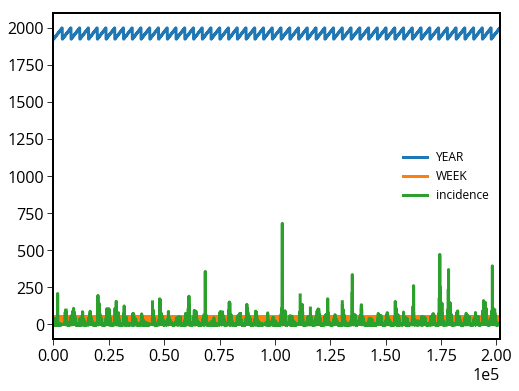

In [23]:
df.plot();

But we can group by the year, and plot the national average each year

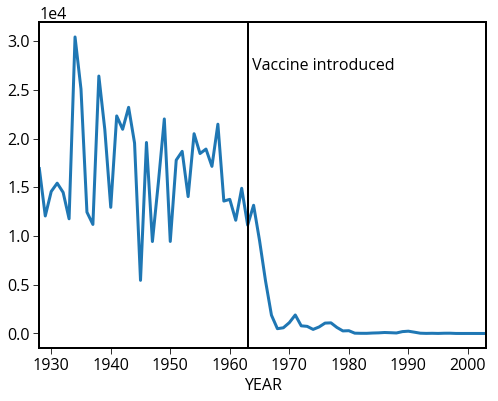

In [24]:
# plot the annual average by year
by_year = df.groupby("YEAR")['incidence'].sum()
ax = by_year.plot()

# add the vaccine year and label
ax.axvline(x=1963, c='k', linewidth=2)
ax.text(1963, 27000, " Vaccine introduced", ha='left');

## Adding interactivity with `hvplot` and `bokeh`

Use the `.hvplot()` to create interactive plots.

In [25]:
# this will add the .hvplot() function to your DataFrame!
import hvplot.pandas

In [26]:
by_year.hvplot(kind='line')

:Curve   [YEAR]   (incidence)

In this case, `.hvplot()` creates a `Holoviews` `Curve` object.

Not unlike `altair` `Chart` objects, it's an object that knows how to translate from your DataFrame data to a visualization.

In [27]:
print(by_year.hvplot())

:Curve   [YEAR]   (incidence)


## Many different chart types are available...

In [28]:
by_year.hvplot(kind='scatter')

:Scatter   [YEAR]   (incidence)

In [29]:
by_year.hvplot(kind='bar', rot=90)

:Bars   [YEAR]   (incidence)

## Just like in altair, we can also layer chart elements together

Use the `*` operator to layer together chart elements.

**Note:** the same thing can be accomplished in altair, but with the `+` operator. 

In [30]:
import holoviews as hv

incidence = by_year.hvplot(kind='line')
vline = hv.VLine(1963).opts(color='black')
label = hv.Text(1963, 27000, " Vaccine introduced", halign='left')

final_chart = incidence * vline * label
final_chart

:Overlay
   .Curve.Incidence :Curve   [YEAR]   (incidence)
   .VLine.I         :VLine   [x,y]
   .Text.I          :Text   [x,y]

## We can group charts by a specific column, with automatic widget selectors

This is some powerful magic.

Let's calculate the annual measles incidence for each year and state:

In [31]:
by_state = df.groupby(['YEAR', 'state'])['incidence'].sum()
by_state.head()

YEAR  state     
1928  ALABAMA       334.99
      ALASKA          0.00
      ARIZONA       200.75
      ARKANSAS      481.77
      CALIFORNIA     69.22
Name: incidence, dtype: float64

Now, tell `hvplot` to plot produce charts for each state:

In [32]:
by_state_chart = by_state.hvplot(x='YEAR', groupby='state', width=400, dynamic=False, kind='line')

by_state_chart * vline

:HoloMap   [state]
   :Overlay
      .Curve.Incidence :Curve   [YEAR]   (incidence)
      .VLine.I         :VLine   [x,y]

## We can select out individual charts from the set of grouped objects

In [33]:
PA = by_state_chart['PENNSYLVANIA'].relabel('PA')
NJ = by_state_chart['NEW JERSEY'].relabel('NJ')

## Combine charts as subplots with the `+` operator

In [34]:
combined = PA + NJ     
combined

:Layout
   .Curve.PA :Curve   [YEAR]   (incidence)
   .Curve.NJ :Curve   [YEAR]   (incidence)

The charts are side-by-side by default. You can also specify the number of rows/columns explicitly.

In [35]:
# one column
combined.cols(1)

:Layout
   .Curve.PA :Curve   [YEAR]   (incidence)
   .Curve.NJ :Curve   [YEAR]   (incidence)

## We can also show overlay lines on the sample plot

Using the `by` keyword:

In [36]:
states = states = ['NEW YORK', 'NEW JERSEY', 'CALIFORNIA', 'PENNSYLVANIA']
sub_states = by_state.loc[:, states]

sub_states.hvplot(x='YEAR', by='state', kind='line') * vline

:Overlay
   .NdOverlay.Incidence :NdOverlay   [state]
      :Curve   [YEAR]   (incidence)
   .VLine.I             :VLine   [x,y]

## We can also show faceted plots

Just like in altair, when we used the `alt.Chart().facet(column='state')` syntax 

Below, we specify the `state` column should be mapped to each column:

In [37]:
sub_states.hvplot(x='YEAR', col='state', 
                  kind='line', width=200, 
                  height=150, rot=90) * vline

:GridSpace   [state]
   :Overlay
      .Curve.Incidence :Curve   [YEAR]   (incidence)
      .VLine.I         :VLine   [x,y]

## Functions for each kind of chart type are available too

In [38]:
by_state.hvplot

## For example, we could plot a bar chart for these four states

In [39]:
by_state.loc[1960:1970, states].hvplot.bar(x='YEAR', 
                                           y='incidence', 
                                           by='state', rot=90)

:Bars   [YEAR,state]   (incidence)

Change `bar()` to `line()` and we get the same thing as before.

In [40]:
by_state.loc[1960:1970, states].hvplot.line(x='YEAR', 
                                            y='incidence', 
                                            by='state', rot=90)

:NdOverlay   [state]
   :Curve   [YEAR]   (incidence)

## Customizing charts

See the help message for explicit hvplot functions:

In [41]:
by_state.hvplot.line?

## Heatmaps are available too...

Can we reproduce the [WSJ measles heatmap](http://graphics.wsj.com/infectious-diseases-and-vaccines/) that we made in altair in week 2? 

Use the help function:

In [42]:
df.hvplot.heatmap?

## Two methods:

We want to plot 'YEAR' on the x axis, 'state' on the y axis, and specify 'incidence' as the values begin plotted in each heatmap bin.

1. use the original, tidy data with columns for state, week, year, and incidence
    - you will need to use the `reduce_function` keyword to sum over weeks
1. Or, you can use the `by_state` dataframe which has already summed over weeks for each state

## Just like altair: save the file as html

In [43]:
import hvplot
hvplot.save(heatmap, 'measles.html')

NameError: name 'heatmap' is not defined

In [ ]:
# load the html file and display it
from IPython.display import HTML
HTML('measles.html')

## One last thing: scatter matrix plots

Visualizing relationships between variables, as we have seen in [seaborn](https://seaborn.pydata.org/examples/scatterplot_matrix.html) and [altair](https://altair-viz.github.io/gallery/scatter_matrix.html)

Let's load the cars data set from week 2

In [44]:
url = "https://raw.githubusercontent.com/MUSA-620-Spring-2019/week-2/master/data/cars.csv"
cars = pd.read_csv(url)

Use the `hvplot.scatter_matrix()` function:

In [45]:
hvplot.scatter_matrix?

In [46]:
columns = ['Horsepower', 'Acceleration', 'Miles_per_Gallon', 'Origin']
hvplot.scatter_matrix(cars[columns], c='Origin')

:GridMatrix   [X,Y]
   :NdOverlay   [Origin]
      :Histogram   [Miles_per_Gallon]   (Miles_per_Gallon_frequency)

Note the "box select" and "lasso" features on the tool bar for interactions

## Recap: altair vs hvplot

- both use a declarative syntax (altair more so than hvplot)
- users of ggplot might be more familiar with altair's syntax
- hvplot integrates directly into pandas dataframes via the `.hvplot()` function

- both have support for cross-filtering and interactions
- both can be incorporated into web-based dashboard via HTML (later in course)
- hvplot has better support for large data (later in course)

#### It's largely up to you which one you feel is easier to use

## hvplot can also be used with geopandas!

Let's load some geographic data for countries:

In [47]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [48]:
world.head()

pop_est      continent                  name iso_a3  gdp_md_est  \
0  28400000.0           Asia           Afghanistan    AFG     22270.0   
1  12799293.0         Africa                Angola    AGO    110300.0   
2   3639453.0         Europe               Albania    ALB     21810.0   
3   4798491.0           Asia  United Arab Emirates    ARE    184300.0   
4  40913584.0  South America             Argentina    ARG    573900.0   

                                            geometry  
0  POLYGON ((61.21081709172574 35.65007233330923,...  
1  (POLYGON ((16.32652835456705 -5.87747039146621...  
2  POLYGON ((20.59024743010491 41.85540416113361,...  
3  POLYGON ((51.57951867046327 24.24549713795111,...  
4  (POLYGON ((-65.50000000000003 -55.199999999999...

## Plotting with just geopandas

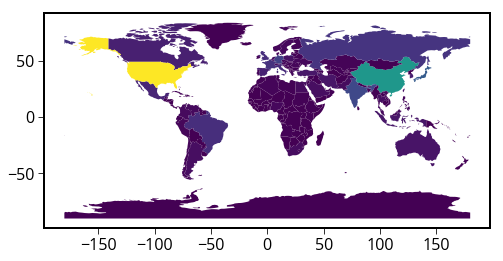

In [49]:
world.plot(column='gdp_md_est')

## Now with hvplot

In [50]:
world.hvplot.polygons?

In [51]:
# can also just do world.hvplot()
world.hvplot.polygons(c='gdp_md_est', geo=True)

:Polygons   [Longitude,Latitude]   (pop_est,continent,name,iso_a3,gdp_md_est)

## Let's try it on our median assessment values per neighborhood

In [52]:
median_values.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-8348795.676844054 4875297.327437357...   
1    Allegheny West  POLYGON ((-8367432.106275852 4866417.819736992...   
2           Andorra  POLYGON ((-8373967.120433775 4875663.023801578...   
3  Aston Woodbridge  POLYGON ((-8349918.769724508 4873746.906470324...   
4   Bartram Village  POLYGON ((-8372041.314282436 4856283.291900341...   

   market_value  
0        185.95  
1         34.75  
2        251.90  
3        183.80  
4         48.30

In [53]:
print(median_values.crs)

{'init': 'epsg:3857', 'no_defs': True}


In [54]:
# pass arguments directly to hvplot() 
# and it recognizes polygons automatically
median_values.hvplot(c='market_value', crs=3857, width=500, height=400)

:Polygons   [Longitude,Latitude]   (ZillowName,market_value)

## Now we can take advantage of GeoViews

Let's add a tile source underneath the choropleth map

In [55]:
import geoviews as gv
import geoviews.tile_sources as gvts

In [56]:
choro = median_values.hvplot(c='market_value', crs=3857, width=500, height=400, alpha=1)
gvts.ESRI * choro

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (ZillowName,market_value)

## Many of the most common tile sources are available..

In [57]:
print(type(gvts.ESRI))

<class 'geoviews.element.geo.WMTS'>


In [58]:
%%opts WMTS [width=200, height=200, xaxis=None, yaxis=None]

(gvts.OSM + gvts.Wikipedia + gvts.StamenToner + gvts.EsriNatGeo +
 gvts.EsriImagery + gvts.EsriUSATopo + gvts.EsriTerrain + gvts.CartoDark).cols(4)

:Layout
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .WMTS.II   :WMTS   [Longitude,Latitude]
   .WMTS.III  :WMTS   [Longitude,Latitude]
   .WMTS.IV   :WMTS   [Longitude,Latitude]
   .WMTS.V    :WMTS   [Longitude,Latitude]
   .WMTS.VI   :WMTS   [Longitude,Latitude]
   .WMTS.VII  :WMTS   [Longitude,Latitude]
   .WMTS.VIII :WMTS   [Longitude,Latitude]

**Note**: we've used the `%%opts` cell magic to apply syling options to any charts generated in the cell.

See [the documentation guide on customizations](http://holoviews.org/user_guide/Notebook_Magics.html) for more details.

## Check out the documentation

- [hvplot user guide](https://hvplot.pyviz.org/user_guide/index.html)
- [pyViz tutorial](http://pyviz.org/tutorial/index.html): introduction to the pyViz ecosystem
- [HoloViews user guide](http://holoviews.org/user_guide/index.html) and [gallery](http://holoviews.org/gallery/index.html)
- [GeoViews user guide](http://geoviews.org/user_guide/index.html) and [gallery](http://geoviews.org/gallery/index.html)

Some **very cool** examples available in the galleries

## Let's take a break...

## Introduction to APIs

Or, how to pull data from the web using Python

## Example APIs

- Socrata Open Data: https://dev.socrata.com/
- Open Data Philly: https://opendataphilly.org
- US Census Bureau: https://www.census.gov/data/developers/data-sets.html

- Bureau of Labor Statistics: https://www.bls.gov/developers/
- US Geological Survey: https://www.usgs.gov/products/data-and-tools/apis
- US Environmental Protection Agency: https://www.epa.gov/enviro/web-services

- Google APIs: https://console.developers.google.com/apis/library?project=cp255-185021
- Facebook: https://developers.facebook.com/docs/apis-and-sdks/
- Twitter: https://developer.twitter.com/en/docs/api-reference-index.html

- Foursquare: https://developer.foursquare.com/
- Instagram: https://www.instagram.com/developer/
- Yelp: https://www.yelp.com/developers

**Note**: when accessing data via API, many services will require you to register an API key to prevent you from overloading the service with requests

## Part 1: Reading an automated data feed

### USGS real-time earthquake feeds
This is an API for near-real-time data about earthquakes, and data is provided in GeoJSON format over the web. 

The API has a separate endpoint for each version of the data that users might want. No authentication is required.

API documentation:

http://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

Sample API endpoint, for magnitude 4.5+ earthquakes in past day:

http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_day.geojson

#### GeoPandas can read GeoJSON from the web directly

Simply pass the URL to the `gpd.read_file()` function:

In [59]:
# download data on magnitude 2.5+ quakes from the past week
endpoint_url = "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
df = gpd.read_file(endpoint_url)

In [60]:
df.head()

id   mag                                           place  \
0    ci37530082  3.28                           8km NE of Aguanga, CA   
1    us2000jh44  4.50                    42km S of Quepos, Costa Rica   
2    us2000jh3g  4.90             29km E of General Luna, Philippines   
3    us2000jh3c  5.20                        188km SE of Esso, Russia   
4  pr2019044008  3.06  89km N of Tierras Nuevas Poniente, Puerto Rico   

            time        updated   tz  \
0  1550043523630  1550049339484 -480   
1  1550042612270  1550046032227 -360   
2  1550040607150  1550041811040  480   
3  1550039669170  1550040501040  720   
4  1550039079290  1550045847129 -240   

                                                 url  \
0  https://earthquake.usgs.gov/earthquakes/eventp...   
1  https://earthquake.usgs.gov/earthquakes/eventp...   
2  https://earthquake.usgs.gov/earthquakes/eventp...   
3  https://earthquake.usgs.gov/earthquakes/eventp...   
4  https://earthquake.usgs.gov/earthquakes/eventp...   

                                              detail   felt  cdi  ...  \
0  https://earthquake.usgs.gov/earthquakes/feed/v...  100.0  3.9  ...   
1  https://earthquake.usgs.gov/earthquakes/feed/v...    1.0  2.0  ...   
2  https://earthquake.usgs.gov/earthquakes/feed/v...    NaN  NaN  ...   
3  https://earthquake.usgs.gov/earthquakes/feed/v...    NaN  NaN  ...   
4  https://earthquake.usgs.gov/earthquakes/feed/v...    2.0  2.7  ...   

   sources                                              types    nst     dmin  \
0     ,ci,  ,dyfi,focal-mechanism,geoserve,nearby-cities,o...  105.0  0.02416   
1     ,us,                  ,dyfi,geoserve,origin,phase-data,    NaN  0.95500   
2     ,us,                       ,geoserve,origin,phase-data,    NaN  2.79200   
3     ,us,                       ,geoserve,origin,phase-data,    NaN  2.03700   
4     ,pr,                  ,dyfi,geoserve,origin,phase-data,   12.0  0.79360   

    rms    gap magType        type  \
0  0.19   19.0      ml  earthquake   
1  1.04  146.0      mb  earthquake   
2  1.13  110.0      mb  earthquake   
3  1.15   70.0      mb  earthquake   
4  0.27  303.0      md  earthquake   

                                               title  \
0                      M 3.3 - 8km NE of Aguanga, CA   
1               M 4.5 - 42km S of Quepos, Costa Rica   
2        M 4.9 - 29km E of General Luna, Philippines   
3                   M 5.2 - 188km SE of Esso, Russia   
4  M 3.1 - 89km N of Tierras Nuevas Poniente, Pue...   

                                     geometry  
0      POINT Z (-116.8014984 33.4881668 5.34)  
1  POINT Z (-84.1091 9.040800000000001 34.46)  
2  POINT Z (126.4282 9.749599999999999 55.81)  
3             POINT Z (160.6704 54.669 91.45)  
4                POINT Z (-66.544 19.2706 25)  

[5 rows x 28 columns]

## Let's plot them on a map:

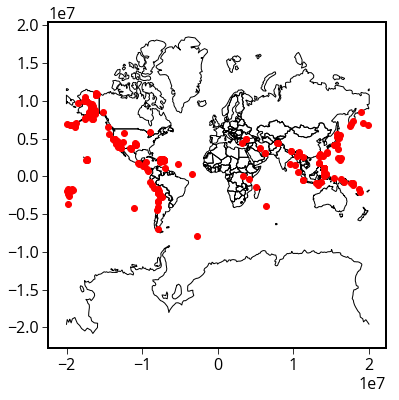

In [61]:
# plot the country outline
ax = world.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black')

# plot the earthquakes
df.to_crs(epsg=3857).plot(ax=ax, color='red');

## Part 2: GeoServices

A GeoService is a standardized format for returning GeoJSON files over the web.

Documentation http://geoservices.github.io/

OpenDataPhilly provides GeoService API endpoints for the geometry hosted on its platform

## Example: Philadelphia ZIP codes

https://www.opendataphilly.org/dataset/zip-codes

In [62]:
# base URL
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Zipcodes_Poly/FeatureServer/0/query?outFields=*&where=1%3D1"

# specify GeoJSON format
url += "&f=geoJSON" 

In [63]:
zip_codes = gpd.read_file(url)

In [64]:
zip_codes.crs

{'init': 'epsg:2272'}

In [65]:
zip_codes.head()

OBJECTID   CODE  COD   Shape__Area  Shape__Length  \
0         1  19120   20  9.177970e+07   49921.544063   
1         2  19121   21  6.959879e+07   39534.887217   
2         3  19122   22  3.591632e+07   24124.645221   
3         4  19123   23  3.585175e+07   26421.728982   
4         5  19124   24  1.448080e+08   63658.770420   

                                            geometry  
0  POLYGON ((2707205.61306597 270949.158484876, 2...  
1  POLYGON ((2685031.68037981 251274.485892043, 2...  
2  POLYGON ((2695823.52920289 248449.927236721, 2...  
3  POLYGON ((2696596.51453356 242841.277364805, 2...  
4  POLYGON ((2711300.79844515 269493.539348885, 2...

## Let's plot it

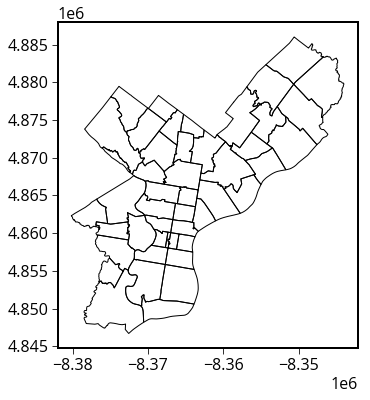

In [66]:
zip_codes.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black');

## Another useful example: census tracts

https://www.opendataphilly.org/dataset/census-tracts

## Part 3: Downloading Philly data from CARTO

- Philadelphia hosts the majority of its open data in the cloud using CARTO. 
- They provide an API to download the data
- You can access the API documentation from OpenDataPhilly

For example: shooting victims in Philadelphia

https://www.opendataphilly.org/dataset/shooting-victims

## SQL Databases

The CARTO databases can be queried using SQL. This allows you to select specific data from the larger database.

CARTO API documentation: https://carto.com/developers/sql-api/

SQL documentation: https://www.postgresql.org/docs/9.1/sql.html

## General Query Syntax

`SELECT [field names] FROM [table name] WHERE [query]`

## Let's try it out in Python

We'll use the `carto-python` library: https://github.com/CartoDB/carto-python

In [67]:
from pyrestcli.auth import NoAuthClient
from carto.sql import SQLClient

Initialize the SQL client object. No authentication is required.

In [68]:
API_endpoint = "https://phl.carto.com"
sql_client = SQLClient(NoAuthClient(API_endpoint))

## Count the total number of rows in a table

The `COUNT` function can be applied to count all rows.

In [69]:
table_name = "shootings"
query = "SELECT COUNT(*) FROM %s" %table_name
print(query)

SELECT COUNT(*) FROM shootings


In [70]:
response = sql_client.send(query)
response

/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pyrestcli/auth.py:79: UserWarning: You are using methods other than get with no authentication!!!
  warnings.warn(_("You are using methods other than get with no authentication!!!"))


{'rows': [{'count': 5278}],
 'time': 0.002,
 'fields': {'count': {'type': 'number'}},
 'total_rows': 1}

**Important:** always good to check how many rows you might be downloading before hand.

## Select all columns, limiting the total number returned

The `LIMIT` function limits the number of returned rows. It is very useful for taking a quick look at the format of a database.

In [71]:
# select the first 5
query = "SELECT * FROM %s LIMIT 5" %table_name

In [72]:
# send the query, specifying a GeoJSON response format
features = sql_client.send(query, format='geojson')
features

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-75.187215, 39.922794]},
   'properties': {'cartodb_id': 1,
    'objectid': 29,
    'year': 2016,
    'dc_key': '201601032572',
    'code': '0111',
    'date_': '2016-07-30T00:00:00Z',
    'race': 'B',
    'sex': 'M',
    'age': '23',
    'wound': 'chest',
    'officer_involved': 'N',
    'offender_injured': 'N',
    'offender_deceased': 'N',
    'location': '2400 BLOCK S 24TH ST',
    'latino': 0,
    'point_x': -75.18721504,
    'point_y': 39.92279354,
    'dist': '01',
    'time': '02:43:00',
    'inside': 0,
    'outside': 1,
    'fatal': 1}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-75.150079, 40.038997]},
   'properties': {'cartodb_id': 2,
    'objectid': 30,
    'year': 2015,
    'dc_key': '201535022853',
    'code': '0411',
    'date_': '2015-03-23T00:00:00Z',
    'race': 'B',
    'sex': 'M',
    'age': '32',
    'wound': 'multi',
    '

Use the `GeoDataFrame.from_features()` function to create a GeoDataFrame

In [73]:
df = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})
df.head()

age  cartodb_id  code                 date_        dc_key dist  fatal  \
0  23           1  0111  2016-07-30T00:00:00Z  201601032572   01      1   
1  32           2  0411  2015-03-23T00:00:00Z  201535022853   35      0   
2  44           3  0411  2016-03-12T00:00:00Z  201618016129   18      0   
3  48           4  0411  2016-01-22T00:00:00Z  201625005325   25      0   
4  23           5  0411  2016-09-15T00:00:00Z  201619084818   19      0   

                               geometry  inside  latino  ... offender_injured  \
0  POINT (-75.18721499999999 39.922794)       0       0  ...                N   
1  POINT (-75.15007900000001 40.038997)       1       0  ...                N   
2           POINT (-75.244152 39.95571)       0       0  ...                N   
3                                  None       0       0  ...                N   
4  POINT (-75.22998800000001 39.965327)       0       0  ...                N   

   officer_involved outside    point_x    point_y  race  sex      time  wound  \
0                 N       1 -75.187215  39.922794     B    M  02:43:00  chest   
1                 N       0 -75.150079  40.038997     B    M  21:36:00  multi   
2                 N       1 -75.244152  39.955710     B    M  20:37:00    leg   
3                 N       1        NaN        NaN     B    M  16:51:00    arm   
4                 N       1 -75.229988  39.965327     B    M  15:35:00  multi   

   year  
0  2016  
1  2015  
2  2016  
3  2016  
4  2016  

[5 rows x 23 columns]

In [74]:
# make sure we remove missing geometries
df = df.loc[df.geometry.notnull()]

## Now let's plot it

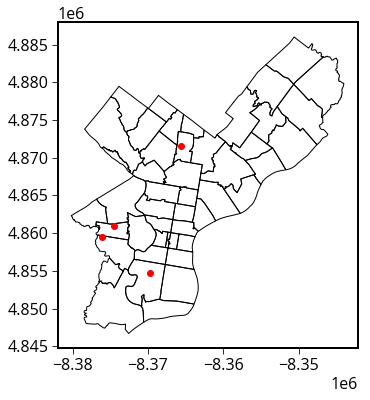

In [75]:
ax = zip_codes.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black')
df.to_crs(epsg=3857).plot(ax=ax, color='red')

## Read all columns, all rows

In [76]:
features = sql_client.send("SELECT * FROM shootings", format='geojson')
shootings = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})
print(len(shootings))

5278


In [77]:
# make sure we remove missing geometries
shootings = shootings.loc[shootings.geometry.notnull()]
shootings = shootings.to_crs(epsg=3857)

## Make a quick scatter plot

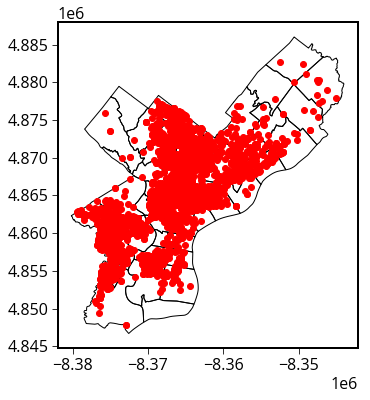

In [78]:
ax = zip_codes.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black')
shootings.plot(ax=ax, color='red');

## More useful: make a hex bin map

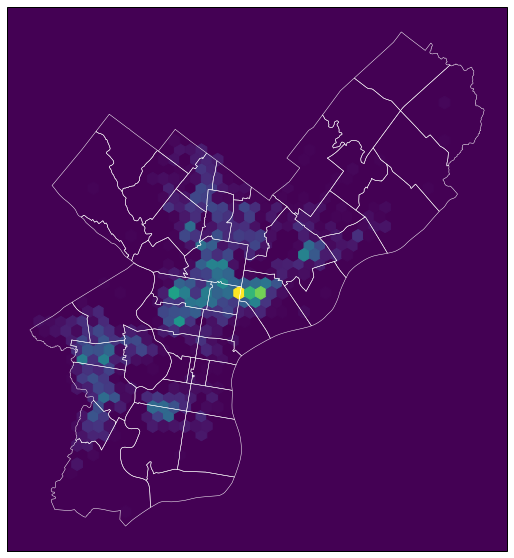

In [79]:
# initialize the axes
ax = plt.axes(projection=ccrs.epsg('3857'))

# convert to Web Mercator and plot the hexbins 
X = shootings.to_crs(epsg=3857)
ax.hexbin(X.geometry.x, X.geometry.y, gridsize=40, mincnt=1, cmap='viridis')

# overlay the ZIP codes
zip_codes.to_crs(epsg=3857).plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='white')

# set background color to lowest viridis color
ax.outline_patch.set_facecolor(plt.get_cmap('viridis')(0))
ax.outline_patch.set_zorder(0)

# larger figure
ax.figure.set_size_inches((10, 10))

## Select by specific column values

In [80]:
shootings.head()

age  cartodb_id  code                 date_        dc_key dist  fatal  \
0  23           1  0111  2016-07-30T00:00:00Z  201601032572   01    1.0   
1  32           2  0411  2015-03-23T00:00:00Z  201535022853   35    0.0   
2  44           3  0411  2016-03-12T00:00:00Z  201618016129   18    0.0   
4  23           5  0411  2016-09-15T00:00:00Z  201619084818   19    0.0   
5  46           6  0411  2015-03-08T00:00:00Z  201518014258   18    0.0   

                                       geometry  inside  latino  ...  \
0  POINT (-8369802.487964381 4854729.248611915)     0.0     0.0  ...   
1   POINT (-8365668.527354281 4871610.83655102)     1.0     0.0  ...   
2  POINT (-8376140.685811678 4859508.263185208)     0.0     0.0  ...   
4  POINT (-8374563.956544082 4860904.972162729)     0.0     0.0  ...   
5  POINT (-8372759.690237304 4859120.960670083)     1.0     0.0  ...   

  offender_injured  officer_involved outside    point_x    point_y  race  sex  \
0                N                 N     1.0 -75.187215  39.922794     B    M   
1                N                 N     0.0 -75.150079  40.038997     B    M   
2                N                 N     1.0 -75.244152  39.955710     B    M   
4                N                 N     1.0 -75.229988  39.965327     B    M   
5                N                 N     0.0 -75.213780  39.953043     B    F   

       time  wound    year  
0  02:43:00  chest  2016.0  
1  21:36:00  multi  2015.0  
2  20:37:00    leg  2016.0  
4  15:35:00  multi  2016.0  
5  10:57:00  multi  2015.0  

[5 rows x 23 columns]

## Select fatal shootings only

In [91]:
query = "SELECT * FROM shootings WHERE fatal = 1.0"

In [92]:
features = sql_client.send(query, format='geojson')
fatal = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})
print("number of fatal shootings = ", len(fatal))

number of fatal shootings =  935


## Select shootings in 2019

Uuse the `DATE` function in SQL

In [ ]:
query = "SELECT * FROM shootings WHERE date_ > DATE '1/1/19'"

In [90]:
features = sql_client.send(query, format='geojson')
this_year = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})
print("number of shootings this year = ", len(this_year))

number of shootings this year =  99


## Explore trends with day of month/week

Convert the date column to `DateTime` objects

In [82]:
shootings['date'] = pd.to_datetime(shootings['date_'])

Use `strftime` to extract parts of the date

For reference: http://strftime.org/

In [83]:
shootings["Month"] = shootings["date"].dt.strftime("%m")
shootings["Day of Week"] = shootings["date"].dt.strftime("%w")

Group shootings by month and day of week.

In [84]:
count = shootings.groupby(['Month', 'Day of Week']).size()
count = count.reset_index(name='Count')
count.head()

Month Day of Week  Count
0    01           0     62
1    01           1     49
2    01           2     75
3    01           3     53
4    01           4     59

Make a heatmap using `hvplot`

In [85]:
heatmap = count.hvplot.heatmap(y="Month", x="Day of Week", 
                               C='Count', cmap='viridis',
                               width=400, height=500, flip_yaxis=True)

heatmap

:HeatMap   [Day of Week,Month]   (Count)

### Trends: more shootings on the weekends and in the summer months

## Your turn...

## Part 1. Verify that there are more shootings in the summer

Group by month and use `hvplot` to make a bar graph of shootings vs month

## Part 2. Verify that there are more shootings on the weekend

Group by day of week and use `hvplot` to make a bar graph of shootings vs day of week

## Part 3: explore a different data set on OpenDataPhilly

- Find a data set on https://www.opendataphilly.org/
- Identify the API documentation (make sure it is available via CARTO)
- Download the data using a SQL query
- Explore the data:
    - try a hex bin map across Philadelphia using `matplotlib`
    - try a time-based heatmap via `hvplot`